<a href="https://colab.research.google.com/github/AaronCWacker/MachineLearning/blob/master/GPT_2_Text_Generating_Model_w_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Cite  -   Minimaxir:  https://github.com/minimaxir/gpt-2-simple
#Cite     

#  Train, Inference, and Web Deploy of GPT-2 Text-Generating Model with GPU For Teaching Comparison

by [Aaron Wacker](https://xr.azurewebsites.net/nlp/)

*Last updated: December 6th, 2020

Text generating neural networks on any text datasets are general purpose AI meaning you can use it for anything in a human reading comprehension fashion which you may then implement the pattern of:

  **Policy Network** to **Value Network** to **Tree Search**
  
    **using `GPT-2` and using `alBERT`**

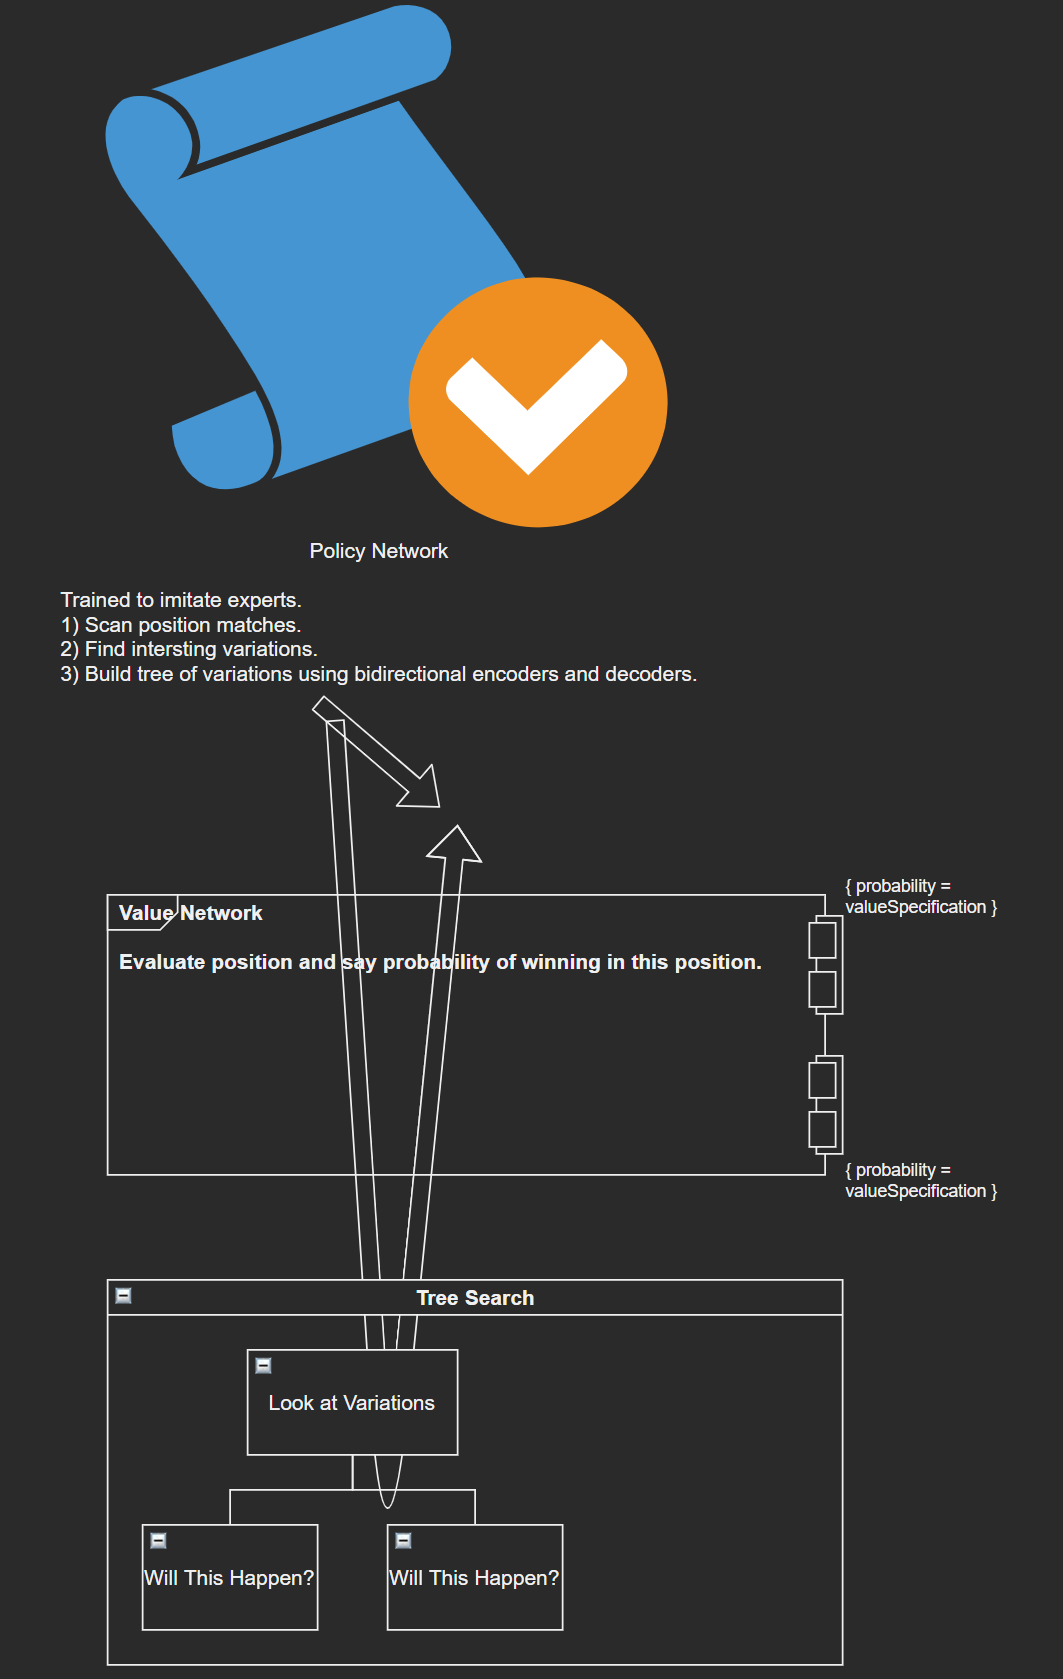



For more about `gpt-2-simple`, you can visit [this GitHub repository](https://github.com/minimaxir/gpt-2-simple). You can also read my [blog post](https://minimaxir.com/2019/09/howto-gpt2/) for more information how to use this notebook!


To get started:

1. Copy this notebook to your Google Drive to keep it and save your changes. (File -> Save a Copy in Drive)
2. Make sure you're running the notebook in Google Chrome.
3. Run the cells below:


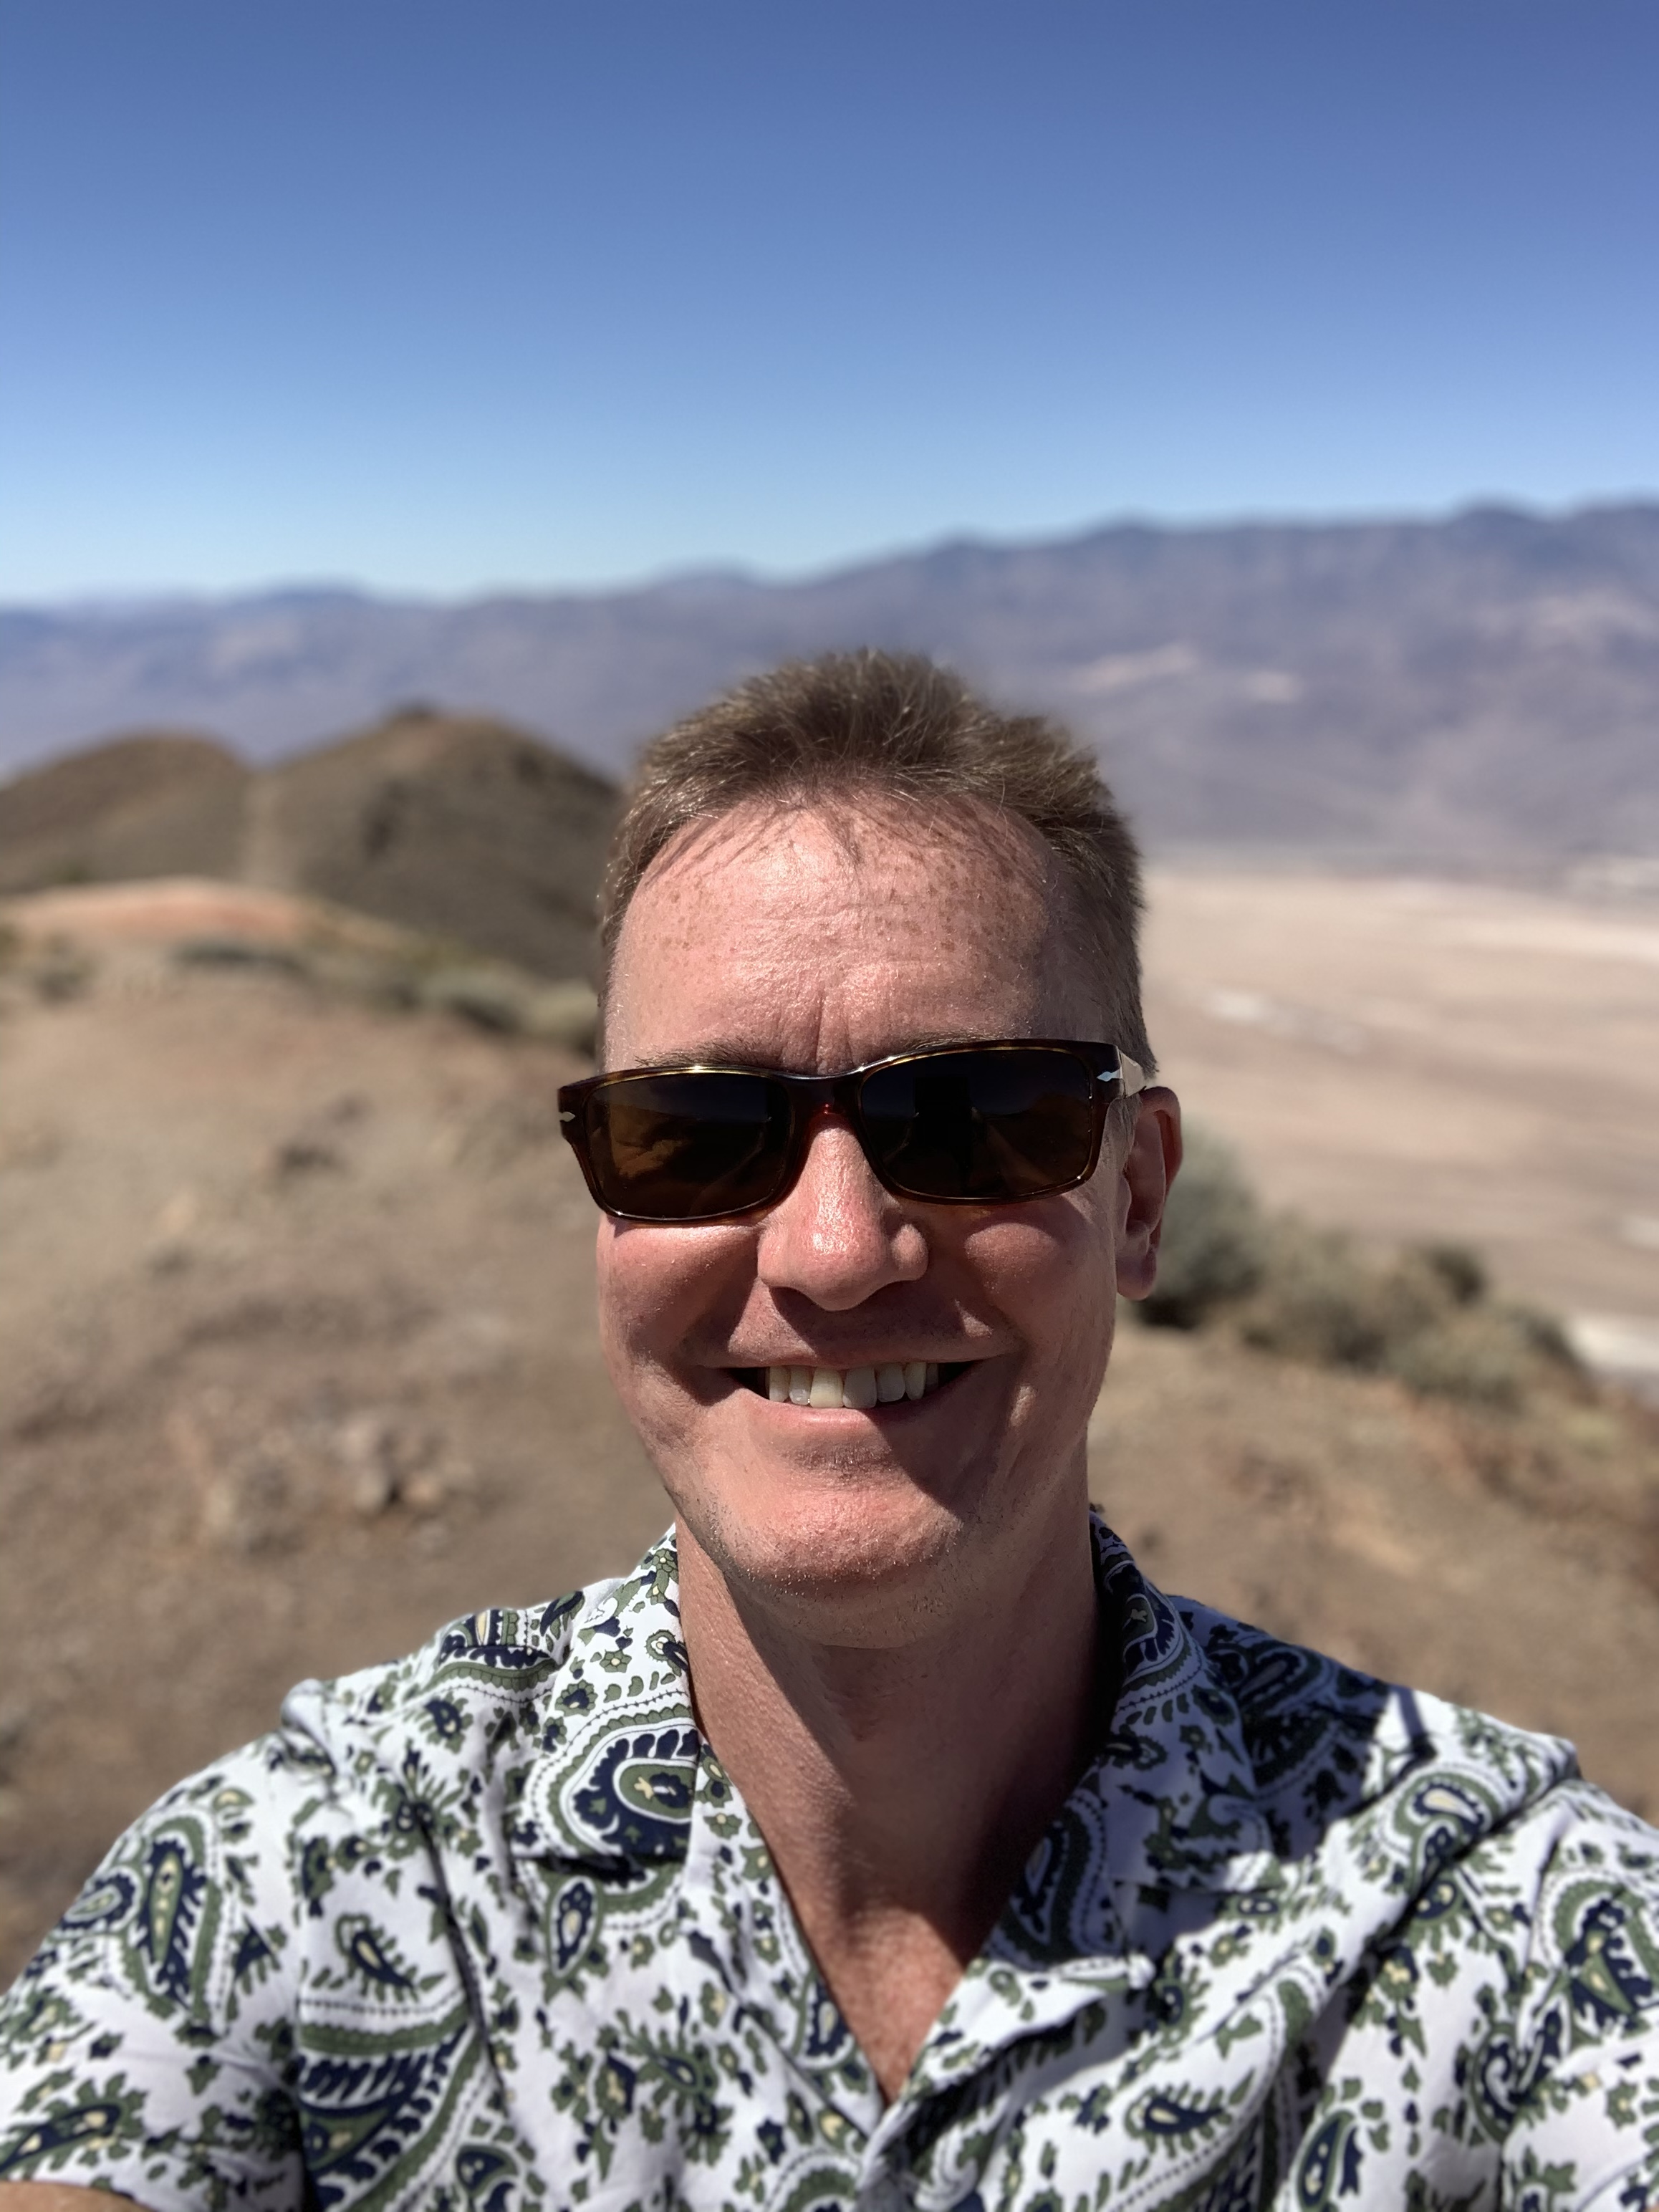

In [ ]:
%tensorflow_version 1.x
!pip install -q gpt-2-simple
import gpt_2_simple as gpt2
from datetime import datetime
from google.colab import files

## GPU

Colaboratory uses either a Nvidia T4 GPU or an Nvidia K80 GPU. The T4 is slightly faster than the old K80 for training GPT-2, and has more memory allowing you to train the larger GPT-2 models and generate more text.

You can verify which GPU is active by running the cell below.

In [ ]:
!nvidia-smi

Sun Dec  6 13:36:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading GPT-2

If you're retraining a model on new text, you need to download the GPT-2 model first. 

There are three released sizes of GPT-2:

* `124M` (default): the "small" model, 500MB on disk.
* `355M`: the "medium" model, 1.5GB on disk.
* `774M`: the "large" model, cannot currently be finetuned with Colaboratory but can be used to generate text from the pretrained model (see later in Notebook)
* `1558M`: the "extra large", true model. Will not work if a K80 GPU is attached to the notebook. (like `774M`, it cannot be finetuned).

Larger models have more knowledge, but take longer to finetune and longer to generate text. You can specify which base model to use by changing `model_name` in the cells below.

The next cell downloads it from Google Cloud Storage and saves it in the Colaboratory VM at `/models/<model_name>`.

This model isn't permanently saved in the Colaboratory VM; you'll have to redownload it if you want to retrain it at a later time.

In [ ]:
gpt2.download_gpt2(model_name="124M")

Fetching checkpoint: 1.05Mit [00:00, 283Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 105Mit/s]                                                    
Fetching hparams.json: 1.05Mit [00:00, 284Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 498Mit [00:12, 41.0Mit/s]                                  
Fetching model.ckpt.index: 1.05Mit [00:00, 256Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 128Mit/s]                                                 
Fetching vocab.bpe: 1.05Mit [00:00, 135Mit/s]                                                       


## Mounting Google Drive

The best way to get input text to-be-trained into the Colaboratory VM, and to get the trained model *out* of Colaboratory, is to route it through Google Drive *first*.

Running this cell (which will only work in Colaboratory) will mount your personal Google Drive in the VM, which later cells can use to get data in/out. (it will ask for an auth code; that auth is not saved anywhere)

In [ ]:
gpt2.mount_gdrive()

Mounted at /content/drive


## Uploading a Text File to be Trained to Colaboratory

In the Colaboratory Notebook sidebar on the left of the screen, select *Files*. From there you can upload files:

![alt text](https://i.imgur.com/TGcZT4h.png)

Upload **any smaller text file**  (<10 MB) and update the file name in the cell below, then run the cell.

In [ ]:
file_name = "shakespeare.txt"

If your text file is larger than 10MB, it is recommended to upload that file to Google Drive first, then copy that file from Google Drive to the Colaboratory VM.

In [ ]:
gpt2.copy_file_from_gdrive(file_name)

FileNotFoundError: ignored

## Finetune GPT-2

The next cell will start the actual finetuning of GPT-2. It creates a persistent TensorFlow session which stores the training config, then runs the training for the specified number of `steps`. (to have the finetuning run indefinitely, set `steps = -1`)

The model checkpoints will be saved in `/checkpoint/run1` by default. The checkpoints are saved every 500 steps (can be changed) and when the cell is stopped.

The training might time out after 4ish hours; make sure you end training and save the results so you don't lose them!

**IMPORTANT NOTE:** If you want to rerun this cell, **restart the VM first** (Runtime -> Restart Runtime). You will need to rerun imports but not recopy files.

Other optional-but-helpful parameters for `gpt2.finetune`:


*  **`restore_from`**: Set to `fresh` to start training from the base GPT-2, or set to `latest` to restart training from an existing checkpoint.
* **`sample_every`**: Number of steps to print example output
* **`print_every`**: Number of steps to print training progress.
* **`learning_rate`**:  Learning rate for the training. (default `1e-4`, can lower to `1e-5` if you have <1MB input data)
*  **`run_name`**: subfolder within `checkpoint` to save the model. This is useful if you want to work with multiple models (will also need to specify  `run_name` when loading the model)
* **`overwrite`**: Set to `True` if you want to continue finetuning an existing model (w/ `restore_from='latest'`) without creating duplicate copies. 

In [ ]:
sess = gpt2.start_tf_sess()

gpt2.finetune(sess,
              dataset=file_name,
              model_name='124M',
              steps=1000,
              restore_from='fresh',
              run_name='run1',
              print_every=10,
              sample_every=200,
              save_every=500
              )

W0828 17:32:14.662547 140648727385984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/gpt_2_simple/src/sample.py:17: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0828 17:32:29.275661 140648727385984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Loading checkpoint models/124M/model.ckpt


  0%|          | 0/1 [00:00<?, ?it/s]

Loading dataset...


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


dataset has 338025 tokens
Training...
[10 | 28.15] loss=3.44 avg=3.44
[20 | 50.13] loss=3.55 avg=3.49
[30 | 72.59] loss=3.45 avg=3.48
[40 | 95.62] loss=3.43 avg=3.47
[50 | 118.93] loss=3.39 avg=3.45
[60 | 141.92] loss=3.20 avg=3.41
[70 | 164.80] loss=3.34 avg=3.40
[80 | 187.81] loss=3.09 avg=3.36
[90 | 210.93] loss=3.19 avg=3.34
[100 | 234.04] loss=3.08 avg=3.31
[110 | 257.12] loss=3.16 avg=3.30
[120 | 280.17] loss=3.21 avg=3.29
[130 | 303.24] loss=3.13 avg=3.28
[140 | 326.38] loss=2.95 avg=3.25
[150 | 349.52] loss=3.04 avg=3.24
[160 | 372.62] loss=2.94 avg=3.22
[170 | 395.74] loss=2.81 avg=3.19
[180 | 418.86] loss=2.72 avg=3.16
[190 | 441.92] loss=3.18 avg=3.16
[200 | 465.01] loss=2.75 avg=3.14
======== SAMPLE 1 ========
.

LUCIO:
How came your father then to enter in Romeo's house
In this ancient city?

ROMEO:
Sir, what a gracious man I was, that I did stay in Romeo's house.

LUCIO:
O, then, you have no time left, my lord.

ROMEO:
O, then I pray you, you are lost.

LUCIO:
I come not,

W0828 18:11:54.318033 140648727385984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


After the model is trained, you can copy the checkpoint folder to your own Google Drive.

If you want to download it to your personal computer, it's strongly recommended you copy it there first, then download from Google Drive. The checkpoint folder is copied as a `.rar` compressed file; you can download it and uncompress it locally.

In [ ]:
gpt2.copy_checkpoint_to_gdrive(run_name='run1')

You're done! Feel free to go to the **Generate Text From The Trained Model** section to generate text based on your retrained model.

## Load a Trained Model Checkpoint

Running the next cell will copy the `.rar` checkpoint file from your Google Drive into the Colaboratory VM.

In [ ]:
gpt2.copy_checkpoint_from_gdrive(run_name='run1')

The next cell will allow you to load the retrained model checkpoint + metadata necessary to generate text.

**IMPORTANT NOTE:** If you want to rerun this cell, **restart the VM first** (Runtime -> Restart Runtime). You will need to rerun imports but not recopy files.

In [ ]:
sess = gpt2.start_tf_sess()
gpt2.load_gpt2(sess, run_name='run1')

## Generate Text From The Trained Model

After you've trained the model or loaded a retrained model from checkpoint, you can now generate text. `generate` generates a single text from the loaded model.

In [ ]:
gpt2.generate(sess, run_name='run1')

A patient and a sworn enemy,
To one manly gentleman helps to make off
One fairer feather: so, happily, I thank thee.

HENRY BOLINGBROKE:
Welcome, Harry; welcome, Somerset: but that
Me too shall be revenged on you.

WARWICK:
O happy friend I had, as it were a curse,
To leave his country of so fair a life!

SOMERSET:
What foul beast is that in your chamber,
Whose big ears and proud eyes shall slander thee
For so blasphemous a charge?

MONTAGUE:
If I thought this was the sweetest, freshest, and lightest
In all my cup of wine, I should be silent.
It drinks me full of the sweets I drink,
And makes me smile more than the sweetest flower.
The more I drink, the more full I feel; and so
The more sweet is the sweet drink I feel,
And the more full full I feel.

KING HENRY VI:
Welcome to London, Somerset, and Lancaster.
Welcome, cousin, to this comfortable bed;
So naked and loathsome are these theots!

QUEEN MARGARET:
What, shall I waken a new man in my sight?

KING HENRY VI:
What, shall I waken a

If you're creating an API based on your model and need to pass the generated text elsewhere, you can do `text = gpt2.generate(sess, return_as_list=True)[0]`

You can also pass in a `prefix` to the generate function to force the text to start with a given character sequence and generate text from there (good if you add an indicator when the text starts).

You can also generate multiple texts at a time by specifing `nsamples`. Unique to GPT-2, you can pass a `batch_size` to generate multiple samples in parallel, giving a massive speedup (in Colaboratory, set a maximum of 20 for `batch_size`).

Other optional-but-helpful parameters for `gpt2.generate` and friends:

*  **`length`**: Number of tokens to generate (default 1023, the maximum)
* **`temperature`**: The higher the temperature, the crazier the text (default 0.7, recommended to keep between 0.7 and 1.0)
* **`top_k`**: Limits the generated guesses to the top *k* guesses (default 0 which disables the behavior; if the generated output is super crazy, you may want to set `top_k=40`)
* **`top_p`**: Nucleus sampling: limits the generated guesses to a cumulative probability. (gets good results on a dataset with `top_p=0.9`)
* **`truncate`**: Truncates the input text until a given sequence, excluding that sequence (e.g. if `truncate='<|endoftext|>'`, the returned text will include everything before the first `<|endoftext|>`). It may be useful to combine this with a smaller `length` if the input texts are short.
*  **`include_prefix`**: If using `truncate` and `include_prefix=False`, the specified `prefix` will not be included in the returned text.

In [ ]:
gpt2.generate(sess,
              length=250,
              temperature=0.7,
              prefix="LORD",
              nsamples=5,
              batch_size=5
              )

LORD WILLOUGHBY:
That, by the way, Clarence and I have done good side by side;
And yet side we, and he side we have done ill.

KING RICHARD II:
Why then 'tis done ill. O, how should I ease it?
Side with him and my brother, my sovereign!
Side wither away, and as night falls,
Like to the farthest morning to my last,
Side wither away, and as morning comes,
Like to the furthest afternoon to my last!
Side wither away, and as our fortunes turn,
Like to the furthest afternoon to our last!

QUEEN MARGARET:
What is this? counsel? counsel!

KING RICHARD II:
My queen and my heir, for half a mile and a half
She will glide this way, to be or no.

QUEEN MARGARET:
So stands the orchard here, for half a mile and a!

KING RICHARD II:
So stands the orchard here, to fence it, to!
Fashion it in her, like the hedgehog's net
LORD STANLEY:
What if I told you, in the hope of succor,
That I had lain a little while in your arms?

DUKE OF YORK:
No doubt, my lord.

QUEEN ELIZABETH:
'Tis a pity I should be coil'd 

For bulk generation, you can generate a large amount of text to a file and sort out the samples locally on your computer. The next cell will generate a generated text file with a unique timestamp.

You can rerun the cells as many times as you want for even more generated texts!

In [ ]:
gen_file = 'gpt2_gentext_{:%Y%m%d_%H%M%S}.txt'.format(datetime.utcnow())

gpt2.generate_to_file(sess,
                      destination_path=gen_file,
                      length=500,
                      temperature=0.7,
                      nsamples=100,
                      batch_size=20
                      )

In [ ]:
# may have to run twice to get file to download
files.download(gen_file)

## Generate Text From The Pretrained Model

If you want to generate text from the pretrained model, not a finetuned model, pass `model_name` to `gpt2.load_gpt2()` and `gpt2.generate()`.

This is currently the only way to generate text from the 774M or 1558M models with this notebook.

In [ ]:
model_name = "774M"

gpt2.download_gpt2(model_name=model_name)

Fetching checkpoint: 1.05Mit [00:00, 354Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 131Mit/s]                                                    
Fetching hparams.json: 1.05Mit [00:00, 279Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 3.10Git [00:23, 131Mit/s]                                  
Fetching model.ckpt.index: 1.05Mit [00:00, 380Mit/s]                                                
Fetching model.ckpt.meta: 2.10Mit [00:00, 226Mit/s]                                                 
Fetching vocab.bpe: 1.05Mit [00:00, 199Mit/s]                                                       


In [ ]:
sess = gpt2.start_tf_sess()

gpt2.load_gpt2(sess, model_name=model_name)

W0828 18:37:58.571830 139905369159552 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Loading pretrained model models/774M/model.ckpt


In [ ]:
gpt2.generate(sess,
              model_name=model_name,
              prefix="The secret of life is",
              length=100,
              temperature=0.7,
              top_p=0.9,
              nsamples=5,
              batch_size=5
              )

The secret of life is that it's really easy to make it complicated," said Bill Nye, the host of the popular science show "Bill Nye the Science Guy." "And this is one of the reasons why we all need to be smarter about science, because we can't keep up with the amazing things that are going on all the time."

While Nye is correct that "everything that's going on all the time" is making the world a better place, he misses the point. This is not
The secret of life is in the rhythm of the universe. It's not a mystery. It's not a mystery to me. It's the nature of the universe. It's the beauty of the universe. It's the way the universe works. It's the way the universe is. It's the way the universe is going to work. It's the way the universe is. It's the way the universe is. It's the way the universe is. It's the way the universe is. It's the way
The secret of life is in the universe.


-

The Red Devil

It's the end of the world as we know it, and the only thing that can save us is a band of 

# Etcetera

If the notebook has errors (e.g. GPU Sync Fail), force-kill the Colaboratory virtual machine and restart it with the command below:

In [ ]:
!kill -9 -1

# LICENSE

MIT License

Copyright (c) 2019 Max Woolf

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.